In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Download and prepare the Flickr 8k dataset

In [2]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                                          extract = True)

image_zip = tf.keras.utils.get_file('Flickr8k.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                                      extract = True)

1115422720/1115419746 [==============================] - 46s 0us/step


In [3]:
image_path = "/content/Flicker8k_Dataset"
dir_Flickr_text = "/content/Flickr8k.token.txt"

We create a dataframe to store the image id and captions for ease of use.

In [4]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


Next let’s see what our current vocabulary size is:-

In [5]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


Next perform some text cleaning such as removing punctuation, single characters, and numeric values:

In [6]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

Now let’s see the size of our vocabulary after cleaning-

In [7]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


Next, we save all the captions and image paths in two lists so that we can load the images at once using the path set. We also add ‘< start >’ and ‘< end >’ tags to every caption so that the model understands the starting and end of each caption.

In [8]:
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [9]:
PATH = "/content/Flicker8k_Dataset/"
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

print(all_img_name_vector[:10])
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

['/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg', '/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg', '/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg', '/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg', '/content/Flicker8k_Dataset/1000268201_693b08cb0e.jpg', '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg', '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg', '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg', '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg', '/content/Flicker8k_Dataset/1001773457_577c3a7d70.jpg']
len(all_img_name_vector) : 40455
len(all_captions) : 40455


We will take only 40000 of each so that we can select batch size properly i.e. 625 batches if batch size= 64. To do this we define a function to limit the dataset to 40000 images and captions.

In [10]:
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

## Preprocess the images using InceptionV3

Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:

 1. Resizing the image to 299px by 299px
 2.Preprocess the images using the preprocess_input method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3

In [16]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-2].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [12]:
train_img_vectors=[]
for path in img_name_vector:
  img,img_path=load_image(path)
  img=np.expand_dims(img,0)
  features = image_features_extract_model(img)
  train_img_vectors.append(features)


In [19]:
train_img_vectors[0].shape

TensorShape([1, 8, 8, 192])

In [13]:
import math
from math import sqrt

def cosineSim(a1,a2):
    sum = 0
    suma1 = 0
    sumb1 = 0
    for i,j in zip(a1, a2):
        suma1 += i * i
        sumb1 += j*j
        sum += i*j
    cosine_sim = sum / ((sqrt(suma1))*(sqrt(sumb1)))
    return cosine_sim

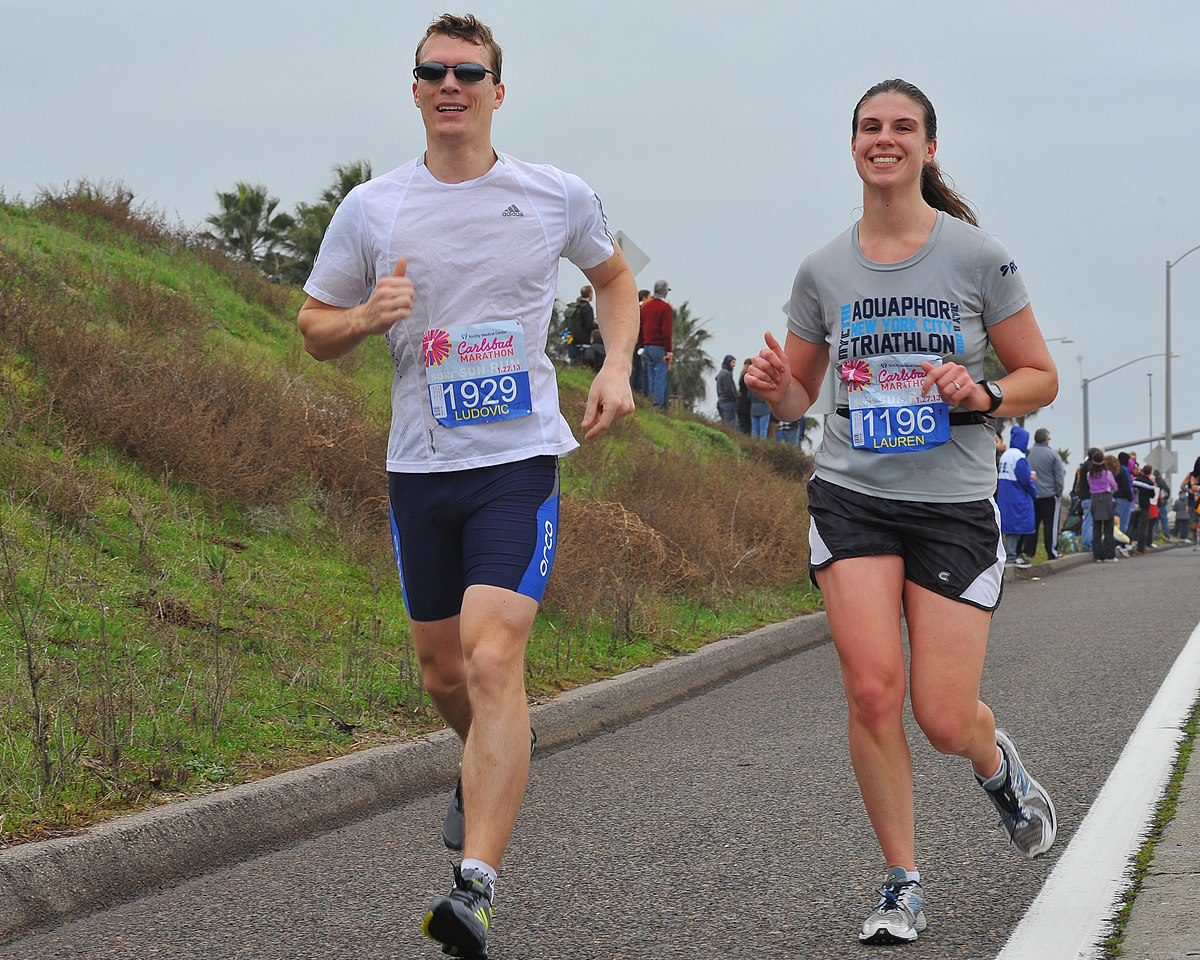

In [35]:
from IPython.display import Image, display
display(Image('/content/running.jpg'))

In [30]:
img,img_path=load_image('/content/running.jpg')
img=np.expand_dims(img,0)
test_features = image_features_extract_model(img)
test_features.shape
test_features=np.reshape(test_features,(12288))
test_cosinesimilarity=[]
for vectors in train_img_vectors:
  vectors=np.reshape(vectors,(12288))
  cosine_similarity=cosineSim(test_features,vectors)
  test_cosinesimilarity.append(cosine_similarity)



In [36]:
max_cosine_similarity_value=max(test_cosinesimilarity)
max_cosine_similarity_value

0.5168245273701153

In [33]:

test_caption=train_captions[test_cosinesimilarity.index(max(test_cosinesimilarity))]

In [34]:
test_caption

'<start>  women and children are playing on paved road <end>'

The caption we got is not relevant
